<a href="https://colab.research.google.com/github/KrushnaTaur/ML-Practice/blob/main/ML_Lab_Experiments/ML_Experiment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 0. Install / import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib   # to save model

In [ ]:
   # <-- change to your path
df = pd.read_csv("/content/Student_Dataset_Cleaned.csv")


In [ ]:
# 2. Quick inspection (uncomment to run)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Target value counts (if 'Target' exists):")
if 'Target' in df.columns:
    print(df['Target'].value_counts())
else:
    # try case-insensitive find
    for c in df.columns:
        if c.lower() == 'target' or 'drop' in c.lower() or 'status' in c.lower():
            print(f"Potential target column: {c}")
            print(df[c].value_counts())
            break

Shape: (4424, 33)
Columns: ['Marital_status', 'Daytime_evening_attendance_', 'Previous_qualification', 'Previous_qualification_grade_', 'Mother_s_qualification', 'Father_s_qualification', 'Mother_s_occupation', 'Father_s_occupation', 'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International', 'Curricular_units_1st_sem_credited_', 'Curricular_units_1st_sem_enrolled_', 'Curricular_units_1st_sem_evaluations_', 'Curricular_units_1st_sem_approved_', 'Curricular_units_1st_sem_without_evaluations_', 'Curricular_units_2nd_sem_credited_', 'Curricular_units_2nd_sem_enrolled_', 'Curricular_units_2nd_sem_evaluations_', 'Curricular_units_2nd_sem_approved_', 'Curricular_units_2nd_sem_without_evaluations_', 'Unemployment_rate', 'Inflation_rate', 'GDP', 'Target', 'Overall_Performance', 'Financial_Stability_Score']
Target value counts (if 'Target' exists):
Target
0    3003
1    1421
Name: count, 

In [ ]:
# 3. Select target column
# Replace 'Target' by your actual target column name if different.
target_col = 'Target'   # <-- change if needed
if target_col not in df.columns:
    # fallback: try to auto-detect a likely target
    candidates = [c for c in df.columns if c.lower() in ('target','outcome','status') or 'drop' in c.lower()]
    if len(candidates) > 0:
        target_col = candidates[0]
    else:
        raise ValueError("Target column not found. Set target_col to your label column name.")

In [ ]:
# 4. Basic cleaning: drop ID and personal info (optional)
# Remove columns that shouldn't be features (IDs, names, email)
drop_cols = [c for c in ['Student_ID','First_Name','Last_Name','Email'] if c in df.columns]
df = df.drop(columns=drop_cols)

In [ ]:
# 5. Handle missing values

from sklearn.impute import SimpleImputer

# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target column from lists if present
target_col = "Target"   # 👈 change if your target column has a different name
if target_col in num_cols:
    num_cols.remove(target_col)
if target_col in cat_cols:
    cat_cols.remove(target_col)

# Impute numeric columns using median
num_imp = SimpleImputer(strategy='median')
df[num_cols] = num_imp.fit_transform(df[num_cols])

# Impute categorical columns using mode (only if exist)
if len(cat_cols) > 0:
    cat_imp = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imp.fit_transform(df[cat_cols])
else:
    print("No categorical columns found — only numeric imputation performed ✅")

print("✅ Missing values handled successfully!")


No categorical columns found — only numeric imputation performed ✅
✅ Missing values handled successfully!


In [ ]:
# 6. Encode categorical features (LabelEncoder for each col)
# Note: for tree-based models, label encoding is fine; for KNN/linear models use one-hot.
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Encode target if it's categorical
if df[target_col].dtype == 'object' or str(df[target_col].dtype).startswith('category'):
    target_le = LabelEncoder()
    df[target_col] = target_le.fit_transform(df[target_col])

In [ ]:
# 7. Feature / target split
X = df.drop(columns=[target_col])
y = df[target_col]

print("\nFeature shape:", X.shape)
print("Class distribution:\n", y.value_counts(normalize=True))



Feature shape: (4424, 32)
Class distribution:
 Target
0.0    0.678797
1.0    0.321203
Name: proportion, dtype: float64


In [ ]:
# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# 9. Baseline: single Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
print("\nSingle Decision Tree Accuracy:", acc_dt)
print("Classification report (DT):\n", classification_report(y_test, y_pred_dt))



Single Decision Tree Accuracy: 0.8169491525423729
Classification report (DT):
               precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       601
         1.0       0.70      0.74      0.72       284

    accuracy                           0.82       885
   macro avg       0.79      0.80      0.79       885
weighted avg       0.82      0.82      0.82       885



In [ ]:
# 1️⃣ Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# 2️⃣ Define features (X) and target (y)
X = df.drop("Target", axis=1)
y = df["Target"]

# 3️⃣ Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4️⃣ Create Bagging Classifier (using Decision Tree as base estimator)
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,        # number of base learners
    max_samples=1.0,        # fraction of samples per estimator
    max_features=1.0,       # fraction of features per estimator
    bootstrap=True,         # use bootstrap sampling
    random_state=42
)

# 5️⃣ Train the Bagging model
bag.fit(X_train, y_train)

# 6️⃣ Make predictions
y_pred = bag.predict(X_test)

# 7️⃣ Evaluate the model
print("✅ Bagging Ensemble Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Bagging Ensemble Model Evaluation
Accuracy: 0.880225988700565

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.95      0.91       601
         1.0       0.86      0.74      0.80       284

    accuracy                           0.88       885
   macro avg       0.88      0.84      0.86       885
weighted avg       0.88      0.88      0.88       885



In [ ]:
# 11. Compare cross-validated accuracy & variance (std) for DT vs Bagging
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_dt = cross_val_score(DecisionTreeClassifier(random_state=42), X, y, cv=cv, scoring='accuracy', n_jobs=-1)
scores_bag = cross_val_score(bag, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

print("Cross-val (5-fold) DecisionTree: Mean {:.4f}, Std {:.4f}".format(scores_dt.mean(), scores_dt.std()))
print("Cross-val (5-fold) Bagging:      Mean {:.4f}, Std {:.4f}".format(scores_bag.mean(), scores_bag.std()))

Cross-val (5-fold) DecisionTree: Mean 0.8013, Std 0.0123
Cross-val (5-fold) Bagging:      Mean 0.8755, Std 0.0090


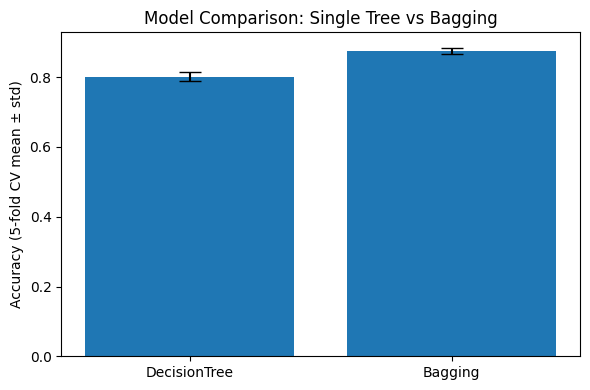

In [ ]:
# 12. Visualize comparison (accuracy bar + error bars using cv std)
models = ['DecisionTree', 'Bagging']
means = [scores_dt.mean(), scores_bag.mean()]
stds = [scores_dt.std(), scores_bag.std()]

plt.figure(figsize=(6,4))
x = np.arange(len(models))
plt.bar(x, means, yerr=stds, capsize=8)
plt.xticks(x, models)
plt.ylabel('Accuracy (5-fold CV mean ± std)')
plt.title('Model Comparison: Single Tree vs Bagging')
plt.tight_layout()
plt.show()

In [ ]:
# 13. Confusion matrix for Bagging (optional)
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix (Bagging):\n", cm)


Confusion matrix (Bagging):
 [[568  33]
 [ 73 211]]


In [ ]:
# 14. Save the trained bagging model
joblib.dump(bag, '/content/bagging_model.pkl')
print("Saved model to /content/bagging_model.pkl")


Saved model to /content/bagging_model.pkl


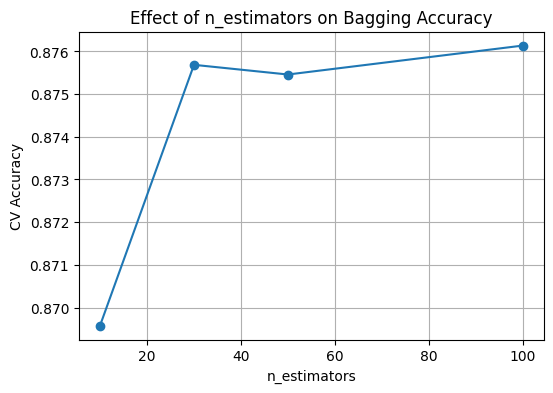

In [ ]:
# 15. (Optional) Tune number of estimators quickly (see effect on accuracy)
est_range = [10, 30, 50, 100]
accs = []
for n in est_range:
    b = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=n, random_state=42, n_jobs=-1)
    scores = cross_val_score(b, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    accs.append(scores.mean())

plt.figure(figsize=(6,4))
plt.plot(est_range, accs, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('CV Accuracy')
plt.title('Effect of n_estimators on Bagging Accuracy')
plt.grid(True)
plt.show()
